# **Bibliotecas**

In [1]:
%%capture

!pip install shap
!pip install optuna

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

# **Funções**

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [3]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [4]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1gCvb72254hSgR3uRDNnkuvypdKMDXE-E --quiet # Colorretal
!gdown 1-5TMUdCHgLEBig1F5a4rRuTT5MdT4Lrw --quiet # Pulmão
!gdown 1-AY70uv61sBGJbUFCiF8Igyes3eP6ymm --quiet # Mama
!gdown 1-ApWhBLZG4NdOtLiwlaYflR2EzTB5vV8 --quiet # Colo de Útero
!gdown 1-HKn3Rk1i9hRAK06khtSF9lf9bInZ3HS --quiet # Próstata
!gdown 1-PJi2-Tu6-AD9PVmVb5Pbx3IzVy8vnr3 --quiet # Pele

In [5]:
# Leitura dos dados de colo de útero
df_prostata = pd.read_csv('prostata.csv')
print(df_prostata.shape)
df_prostata.head(3)

(94106, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


In [6]:
# Valores faltantes
df_prostata.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [7]:
df_prostata_ano1 = df_prostata[~((df_prostata.obito_geral == 0) & (df_prostata.sobrevida_ano1 == 0))].reset_index(drop=True)
df_prostata_ano1.head(3)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


In [8]:
# Correlação com a saída
corr_matrix = df_prostata_ano1.corr()
abs(corr_matrix['sobrevida_ano1']).sort_values(ascending=False).head(20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


sobrevida_ano1        1.000000
sobrevida_ano3        0.391550
obito_geral           0.285800
sobrevida_ano5        0.245725
TRATCONS              0.147407
DIAGTRAT              0.145114
NENHUM                0.130322
IDADE                 0.109142
DIAGPREV              0.093740
CIRURGIA              0.077361
RADIO                 0.075219
CATEATEND             0.072795
ESCOLARI_preench      0.063024
presenca_rec          0.062988
ANODIAG               0.048336
QUIMIO                0.036327
CONSDIAG              0.027112
IBGEATEN              0.023051
IBGE_idem_IBGEATEN    0.013312
RRAS                  0.011663
Name: sobrevida_ano1, dtype: float64

In [9]:
# Quantidade de pacientes em cada classe da saída
df_prostata_ano1.sobrevida_ano1.value_counts()

1    85577
0     4421
Name: sobrevida_ano1, dtype: int64

## **Pré-processamento**

In [10]:
df_prostata_ano1.columns

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'TOPO', 'TOPOGRUP',
       'EC', 'TRATHOSP', 'NENHUM', 'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO',
       'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG',
       'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench',
       'IBGE_idem_IBGEATEN', 'presenca_rec', 'obito_geral', 'sobrevida_ano1',
       'sobrevida_ano3', 'sobrevida_ano5'],
      dtype='object')

In [11]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano3',
             'sobrevida_ano5']

lb = 'sobrevida_ano1'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_prostata_ano1,
                                                                       list_drop, lb,
                                                                    #    ohe_encoder=['TRATHOSP'],
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (67498, 25), X_test = (22500, 25)
y_train = (67498,), y_test = (22500,)


In [12]:
y_train.value_counts(normalize=True)

1    0.950873
0    0.049127
Name: sobrevida_ano1, dtype: float64

In [13]:
y_test.value_counts(normalize=True)

1    0.950889
0    0.049111
Name: sobrevida_ano1, dtype: float64

In [14]:
# # Dataset de treinamento de Próstata
# prost_treino = pd.DataFrame(X_train, columns=feat_cols)
# prost_treino['TOPOGRUP'] = 1
# prost_treino['sobrevida_1ano'] = y_train.values
# prost_treino.to_csv('prost_treino_1ano.csv', index=False, encoding='UTF-8')

# # Dataset de teste de Próstata
# prost_teste = pd.DataFrame(X_test, columns=feat_cols)
# prost_teste['TOPOGRUP'] = 1
# prost_teste['sobrevida_1ano'] = y_test.values
# prost_teste.to_csv('prost_teste_1ano.csv', index=False, encoding='UTF-8')

# **Treinamento e validação dos modelos de machine learning**

## **Random Forest**


### **Modelo Base**

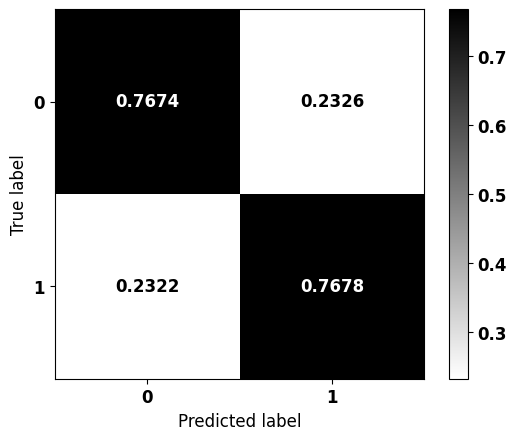


              precision    recall  f1-score   support

           0     0.1458    0.7674    0.2451      1105
           1     0.9846    0.7678    0.8628     21395

    accuracy                         0.7678     22500
   macro avg     0.5652    0.7676    0.5539     22500
weighted avg     0.9434    0.7678    0.8324     22500



In [15]:
# Criação e treinamento do modelo Random Forest
rf = RandomForestClassifier(random_state=seed,
                            class_weight={0:26.47, 1:1},
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

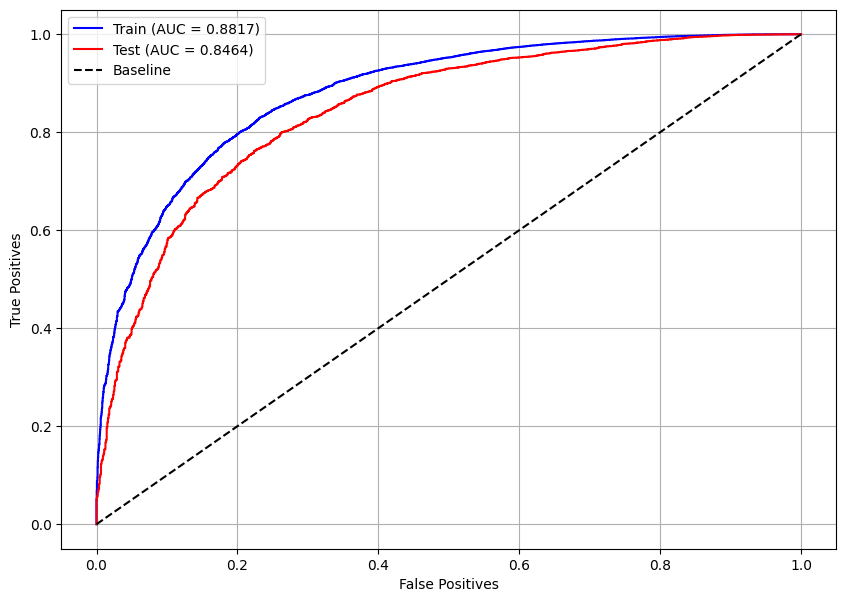

In [ ]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


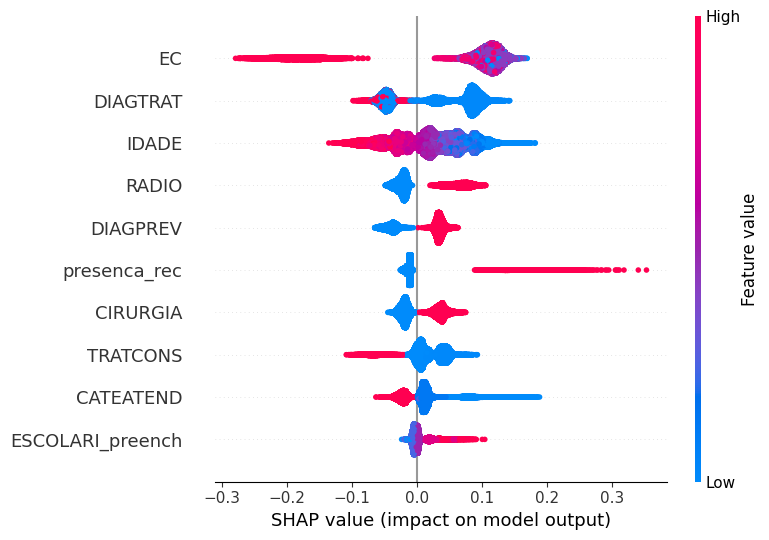

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(rf, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    # optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                #  criterion=optimizer,
                                 random_state=seed,
                                 n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.9539838198251595], datetime_start=datetime.datetime(2023, 10, 11, 12, 31, 21, 146277), datetime_complete=datetime.datetime(2023, 10, 11, 12, 32, 51, 584856), params={'n_estimators': 128, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_samples': 0.8999999999999999, 'criterion': 'entropy'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=8, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=3, value=None)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 128,
 'max_depth': 8,
 'min_samples_split': 6,
 'min_samples_leaf': 6,
 'max_samples': 0.8999999999999999,
 'criterion': 'entropy'}

In [ ]:
pesos = np.round(np.arange(26.5, 26.7, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

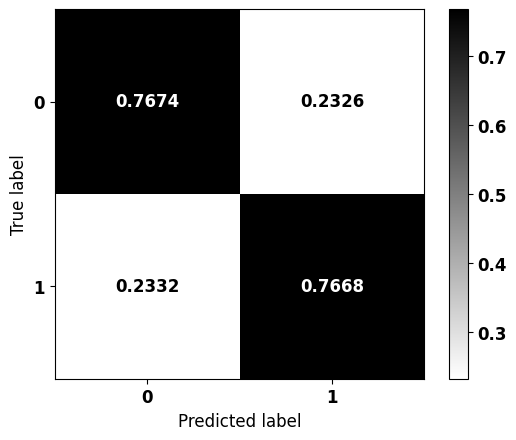


              precision    recall  f1-score   support

           0     0.1453    0.7674    0.2443      1105
           1     0.9846    0.7668    0.8621     21395

    accuracy                         0.7668     22500
   macro avg     0.5649    0.7671    0.5532     22500
weighted avg     0.9434    0.7668    0.8318     22500



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:26.51, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

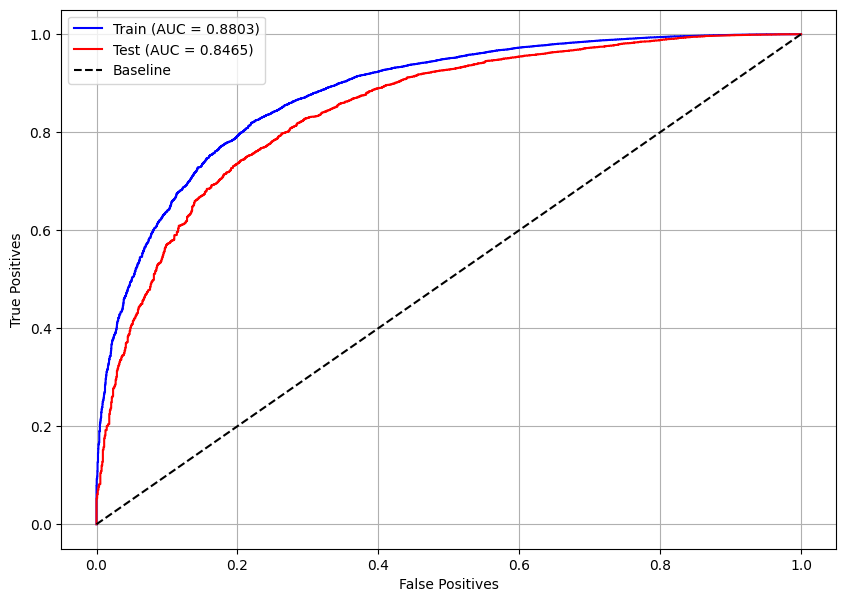

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 95,
 'max_depth': 7,
 'min_samples_split': 9,
 'min_samples_leaf': 3,
 'max_samples': 1.0,
 'criterion': 'entropy'}

In [ ]:
pesos = np.round(np.arange(24.75, 27, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

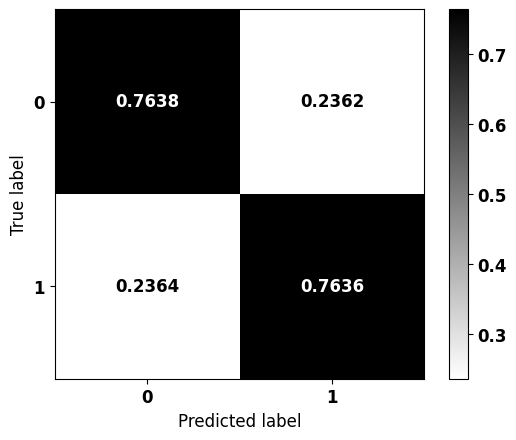


              precision    recall  f1-score   support

           0     0.1430    0.7638    0.2409      1105
           1     0.9843    0.7636    0.8600     21395

    accuracy                         0.7636     22500
   macro avg     0.5637    0.7637    0.5505     22500
weighted avg     0.9430    0.7636    0.8296     22500



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:24.95, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

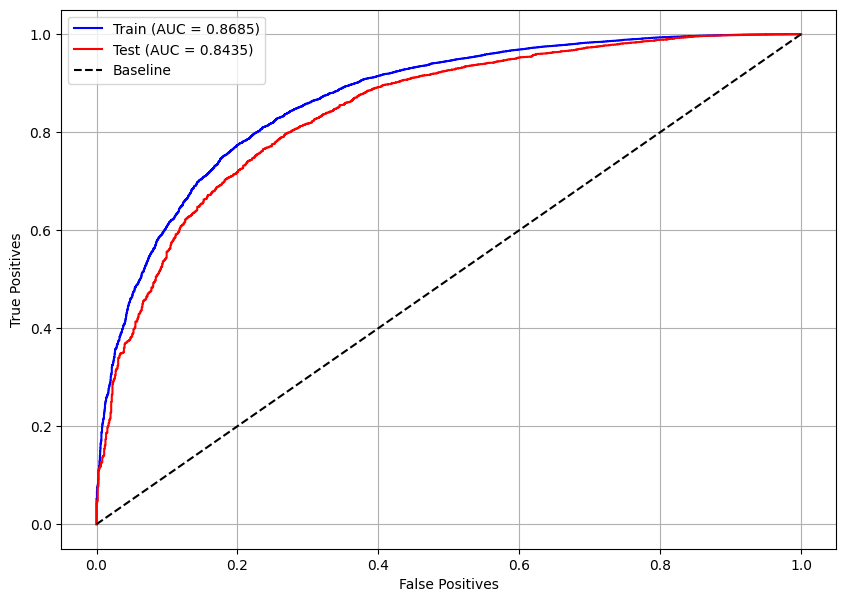

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 97,
 'max_depth': 6,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_samples': 0.8999999999999999}

In [ ]:
pesos = np.round(np.arange(25, 25.25, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

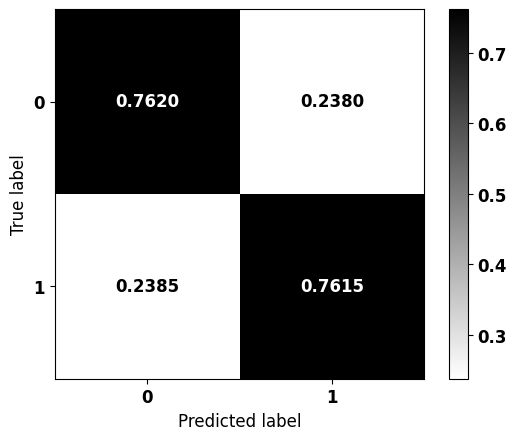


              precision    recall  f1-score   support

           0     0.1416    0.7620    0.2389      1105
           1     0.9841    0.7615    0.8586     21395

    accuracy                         0.7615     22500
   macro avg     0.5629    0.7617    0.5487     22500
weighted avg     0.9427    0.7615    0.8282     22500



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:25.151, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

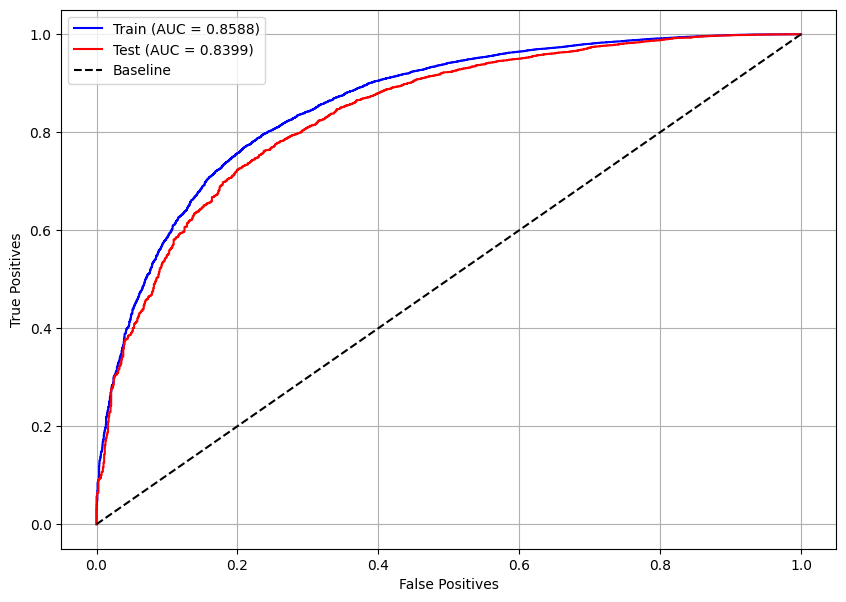

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

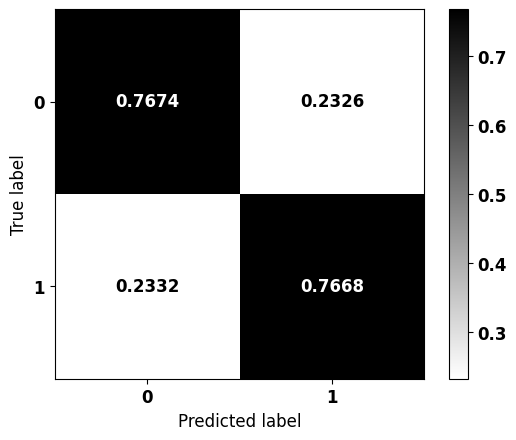


              precision    recall  f1-score   support

           0     0.1453    0.7674    0.2443      1105
           1     0.9846    0.7668    0.8621     21395

    accuracy                         0.7668     22500
   macro avg     0.5649    0.7671    0.5532     22500
weighted avg     0.9434    0.7668    0.8318     22500



In [16]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 128, 'max_depth': 8, 'min_samples_split': 6,
          'min_samples_leaf': 6, 'max_samples': 0.9, 'criterion': 'entropy'}

params['random_state'] = seed
params['class_weight'] = {0:26.51, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

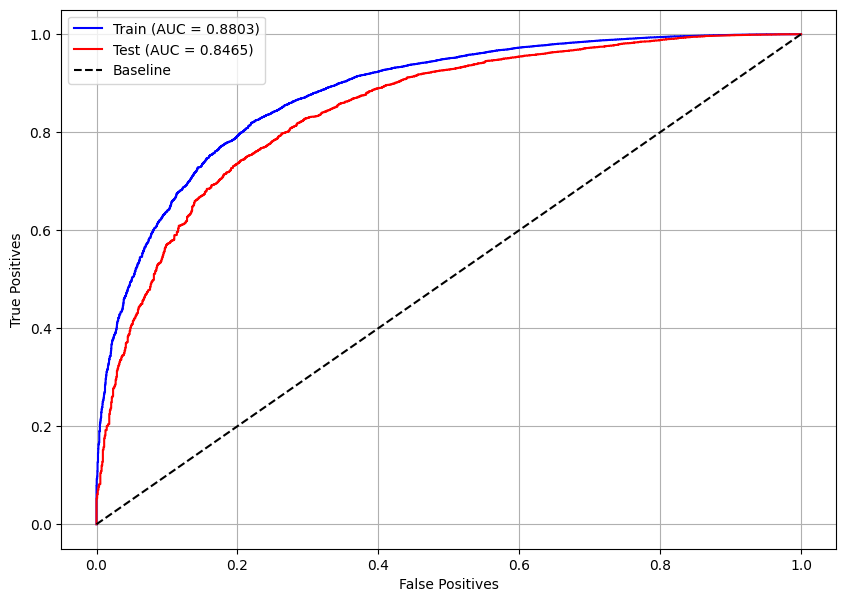

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

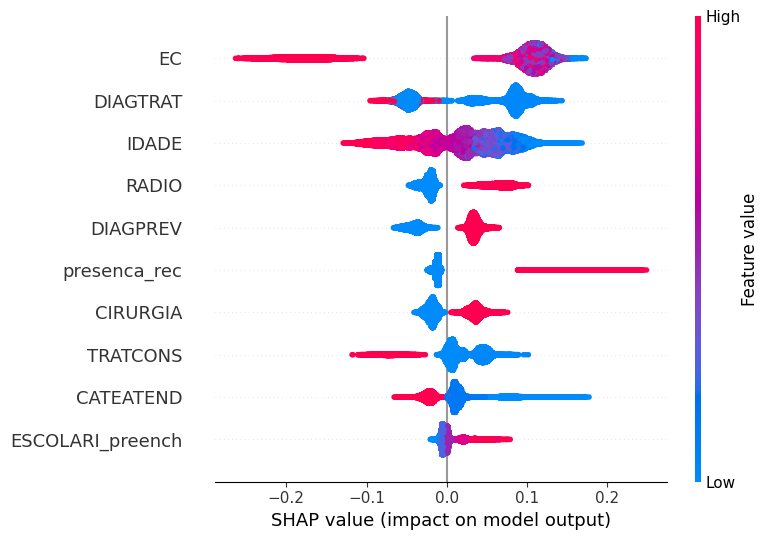

In [ ]:
# Importância das features pelos valores SHAP do modelo otimizado
plot_shap_values(rf_optuna, X_train, feat_cols)

## **XGBoost**


### **Modelo Base**

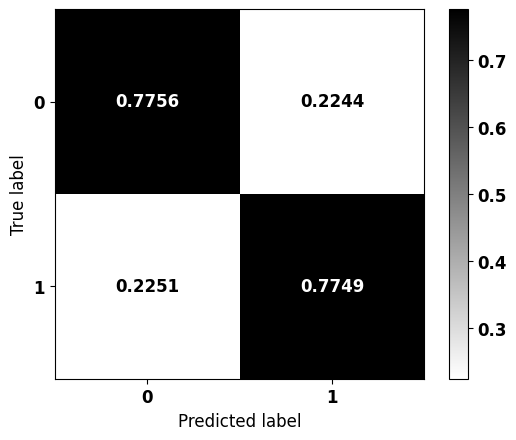


              precision    recall  f1-score   support

           0     0.1511    0.7756    0.2529      1105
           1     0.9853    0.7749    0.8675     21395

    accuracy                         0.7749     22500
   macro avg     0.5682    0.7752    0.5602     22500
weighted avg     0.9443    0.7749    0.8373     22500



In [17]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=0.04362,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

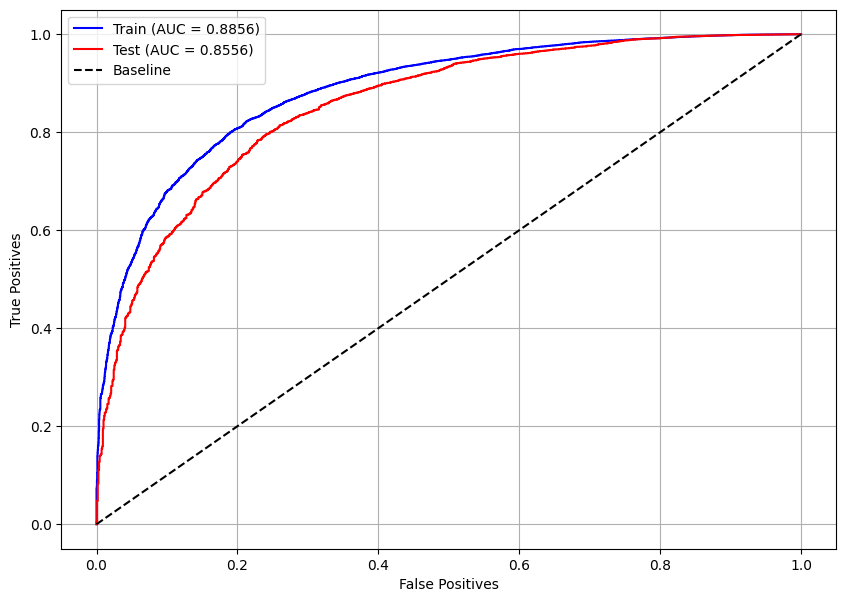

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

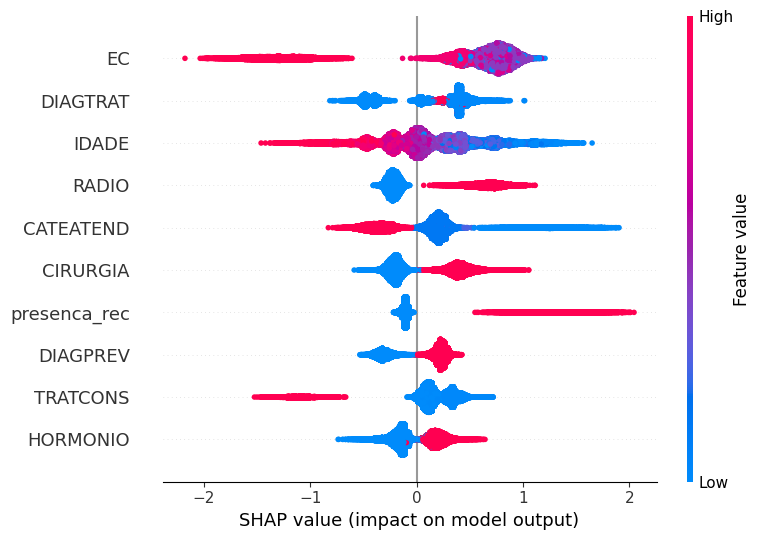

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=63, state=TrialState.COMPLETE, values=[0.954517166329168], datetime_start=datetime.datetime(2023, 10, 11, 15, 55, 8, 266494), datetime_complete=datetime.datetime(2023, 10, 11, 15, 55, 22, 92710), params={'n_estimators': 112, 'max_depth': 4, 'learning_rate': 0.15000000000000002, 'gamma': 0.2, 'min_child_weight': 2, 'colsample_bytree': 0.7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=6, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=63, value=None)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 112,
 'max_depth': 4,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.2,
 'min_child_weight': 2,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(0.042, 0.044, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

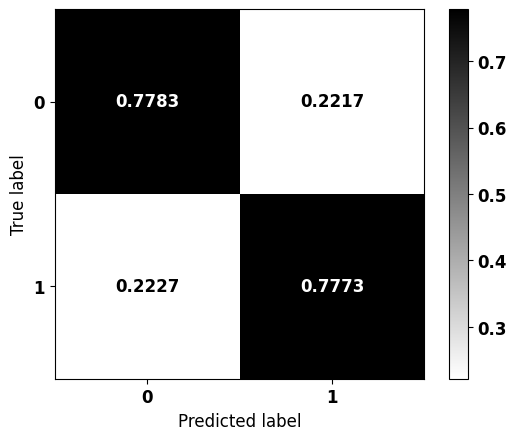


              precision    recall  f1-score   support

           0     0.1529    0.7783    0.2556      1105
           1     0.9855    0.7773    0.8691     21395

    accuracy                         0.7774     22500
   macro avg     0.5692    0.7778    0.5624     22500
weighted avg     0.9446    0.7774    0.8390     22500



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params

params['random_state'] = seed
params['scale_pos_weight'] = 0.0428

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

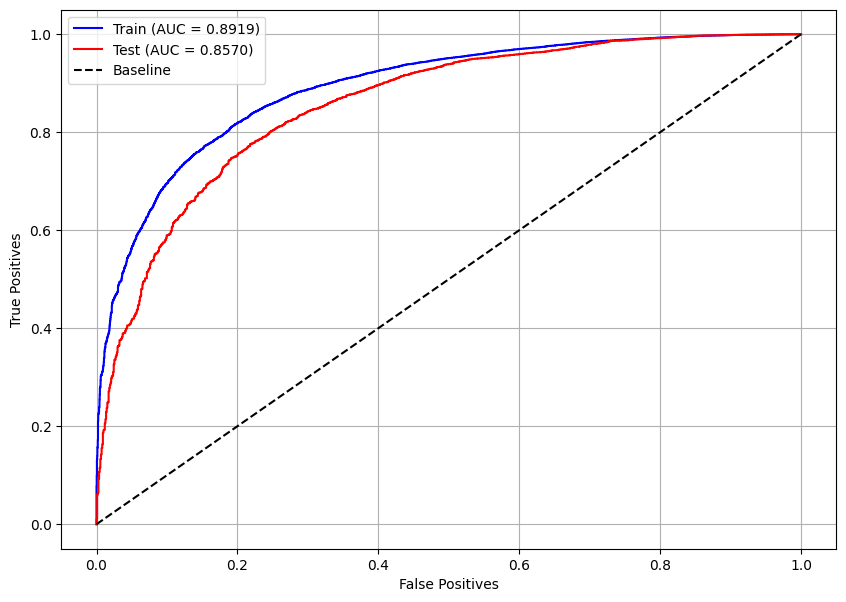

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 123,
 'max_depth': 4,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.0,
 'min_child_weight': 3,
 'colsample_bytree': 0.6000000000000001}

In [25]:
pesos = np.round(np.arange(0.041, 0.044, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

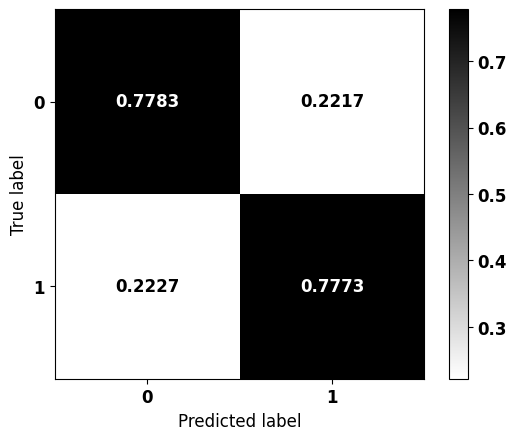


              precision    recall  f1-score   support

           0     0.1529    0.7783    0.2556      1105
           1     0.9855    0.7773    0.8691     21395

    accuracy                         0.7774     22500
   macro avg     0.5692    0.7778    0.5624     22500
weighted avg     0.9446    0.7774    0.8390     22500



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.0429

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

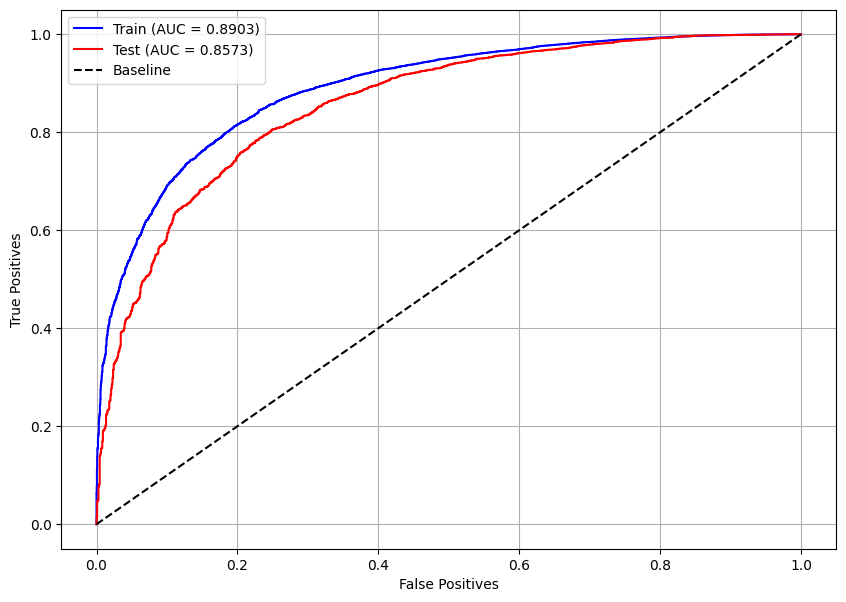

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 97,
 'max_depth': 5,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.04, 0.044, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

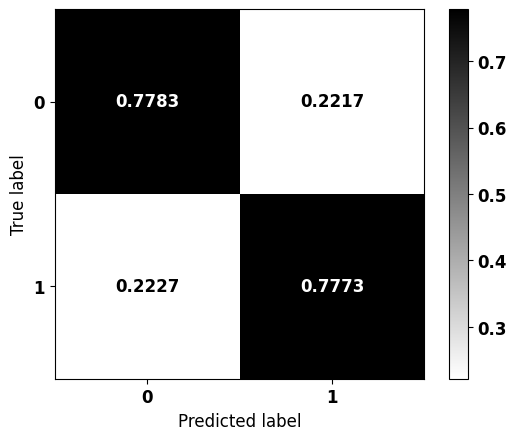


              precision    recall  f1-score   support

           0     0.1529    0.7783    0.2556      1105
           1     0.9855    0.7773    0.8691     21395

    accuracy                         0.7774     22500
   macro avg     0.5692    0.7778    0.5624     22500
weighted avg     0.9446    0.7774    0.8390     22500



In [28]:
# Modelo com os melhores parâmetros
# params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.04133

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

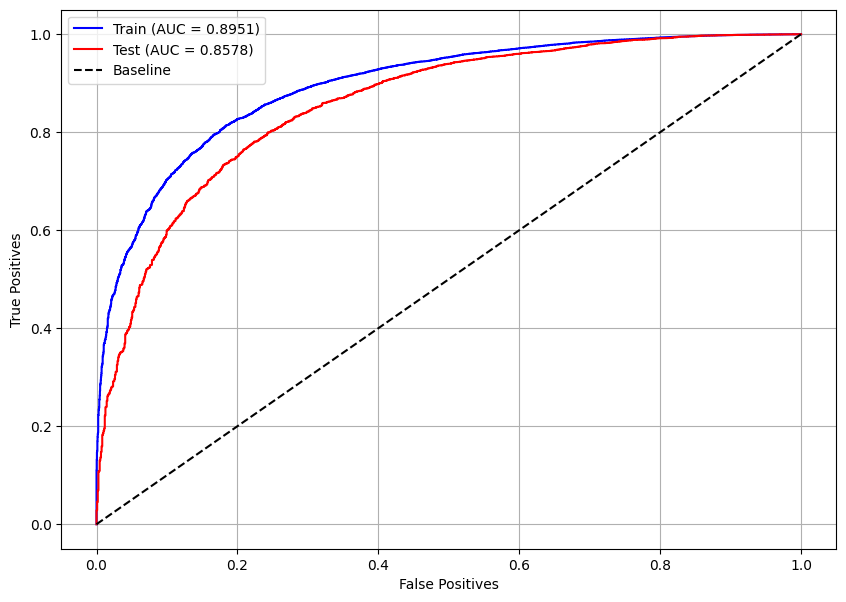

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

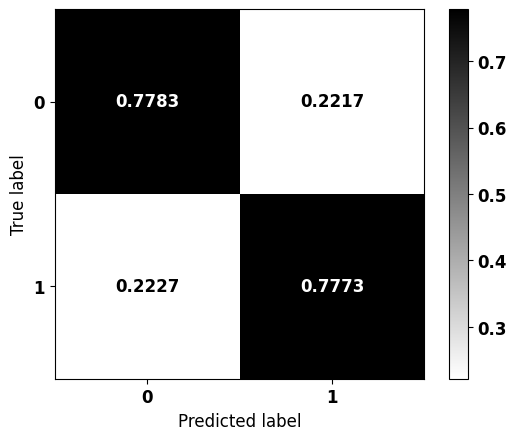


              precision    recall  f1-score   support

           0     0.1529    0.7783    0.2556      1105
           1     0.9855    0.7773    0.8691     21395

    accuracy                         0.7774     22500
   macro avg     0.5692    0.7778    0.5624     22500
weighted avg     0.9446    0.7774    0.8390     22500



In [31]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.15,
          'gamma': 0.0, 'min_child_weight': 3, 'colsample_bytree': 0.6}

params['random_state'] = seed
params['scale_pos_weight'] = 0.0429

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

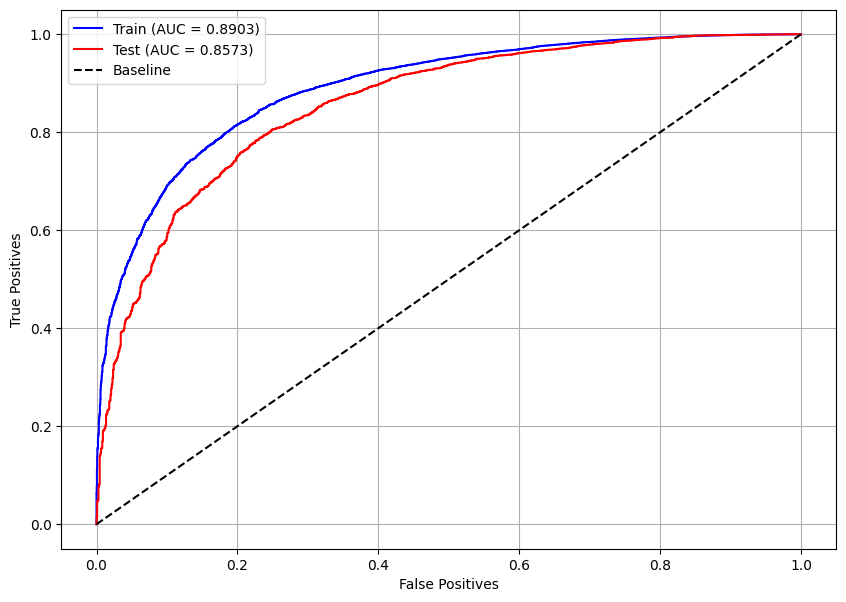

In [32]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

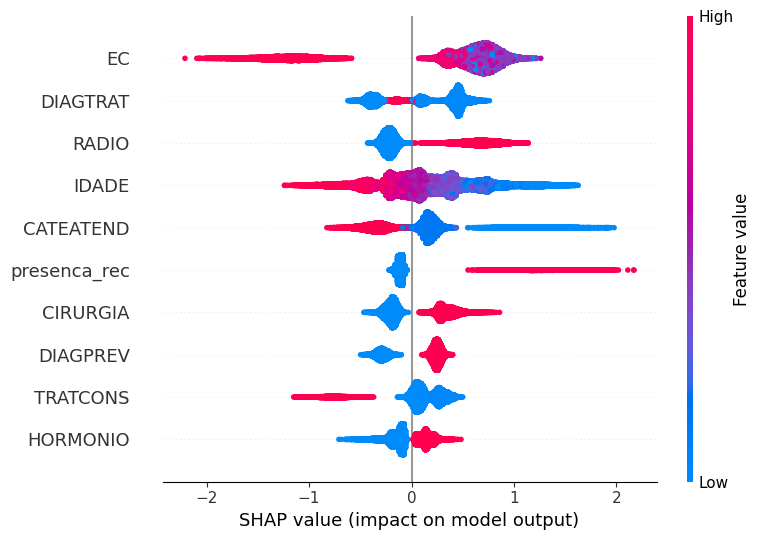

In [33]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

## **LightGBM**


### **Modelo Base**

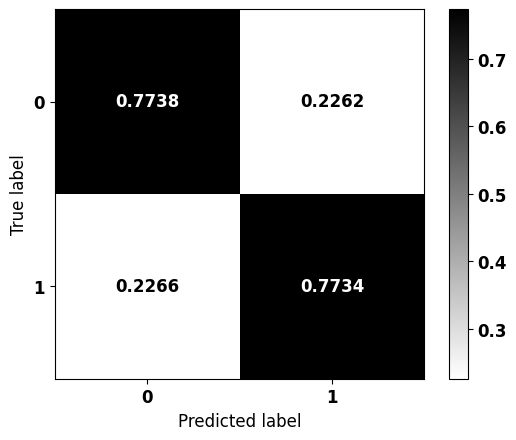


              precision    recall  f1-score   support

           0     0.1499    0.7738    0.2512      1105
           1     0.9851    0.7734    0.8665     21395

    accuracy                         0.7734     22500
   macro avg     0.5675    0.7736    0.5588     22500
weighted avg     0.9441    0.7734    0.8363     22500



In [34]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=4,
                      class_weight={0:23, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

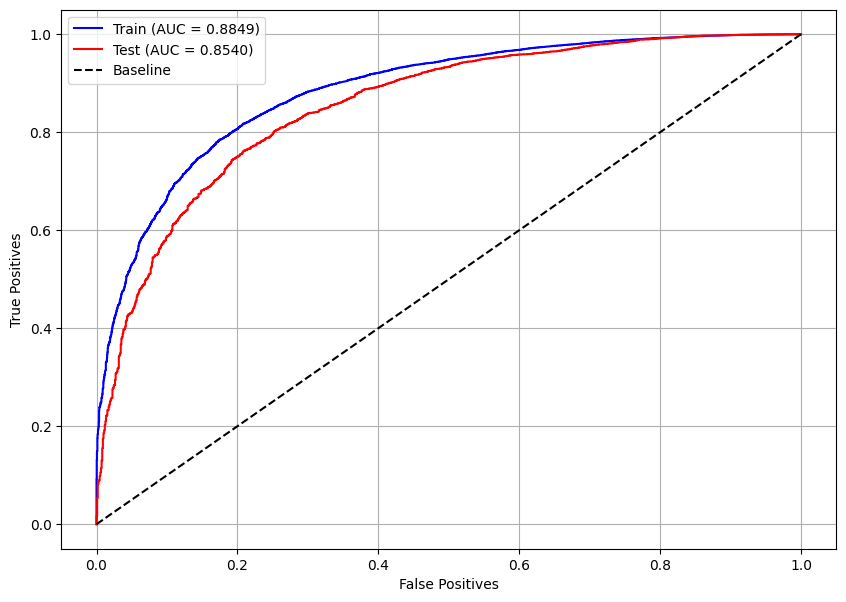

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

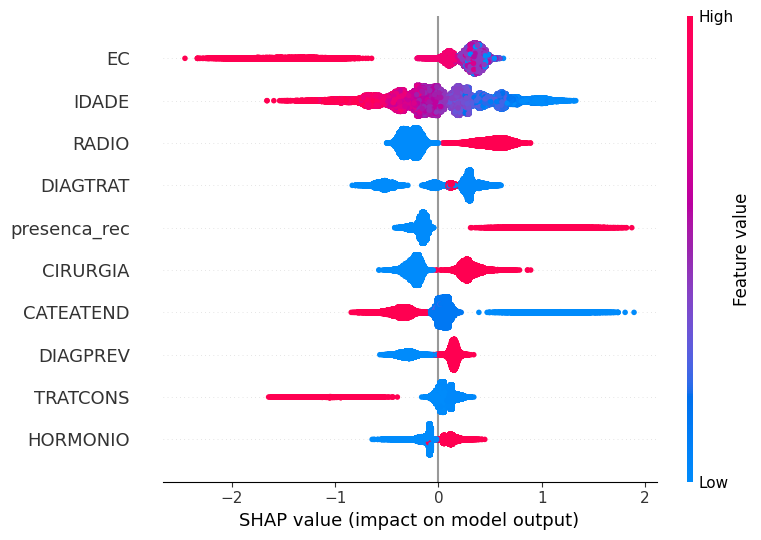

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyLGBM.best_trial

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.954383832995835], datetime_start=datetime.datetime(2023, 10, 11, 16, 22, 15, 414552), datetime_complete=datetime.datetime(2023, 10, 11, 16, 22, 39, 484859), params={'n_estimators': 143, 'max_depth': 4, 'learning_rate': 0.08, 'min_child_weight': 2, 'colsample_bytree': 0.7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=4, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=0, value=None)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 143,
 'max_depth': 4,
 'learning_rate': 0.08,
 'min_child_weight': 2,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(23.3, 23.5, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

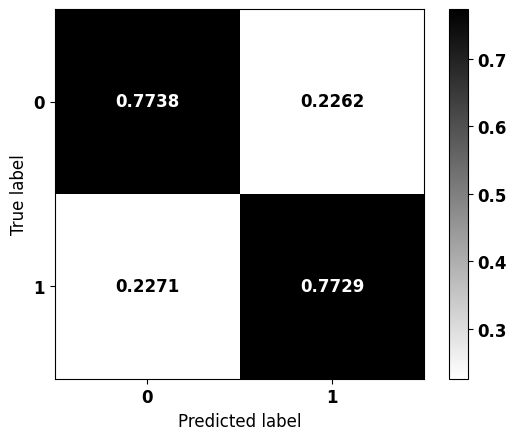


              precision    recall  f1-score   support

           0     0.1497    0.7738    0.2508      1105
           1     0.9851    0.7729    0.8662     21395

    accuracy                         0.7730     22500
   macro avg     0.5674    0.7733    0.5585     22500
weighted avg     0.9441    0.7730    0.8360     22500



In [38]:
# Modelo com os melhores parâmetros
# params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:23.385, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

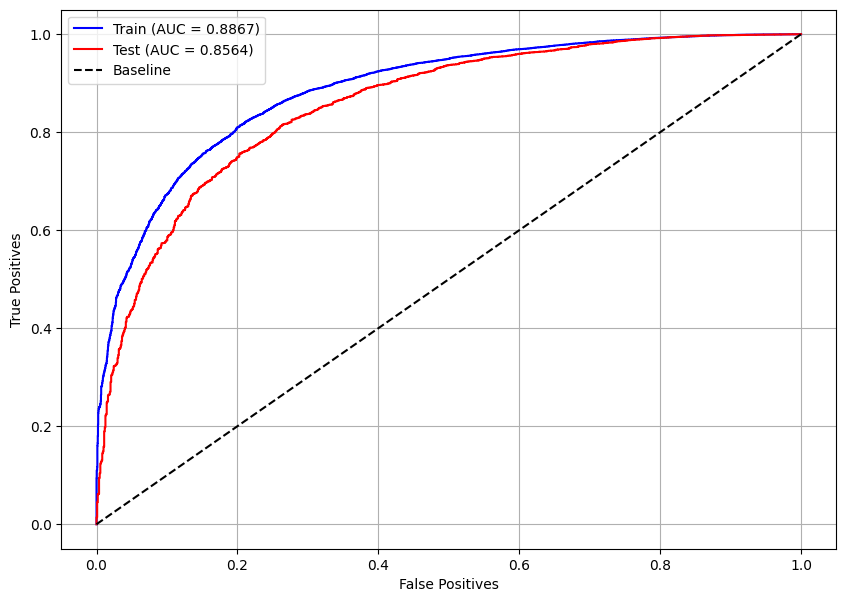

In [39]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 89,
 'max_depth': 4,
 'learning_rate': 0.16999999999999998,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(23, 23.2, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

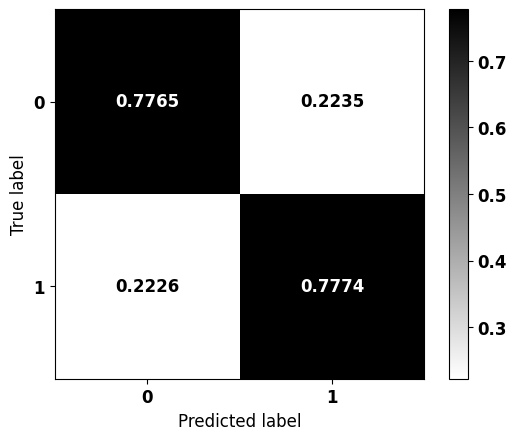


              precision    recall  f1-score   support

           0     0.1527    0.7765    0.2552      1105
           1     0.9854    0.7774    0.8691     21395

    accuracy                         0.7774     22500
   macro avg     0.5690    0.7769    0.5621     22500
weighted avg     0.9445    0.7774    0.8390     22500



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:23.13, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

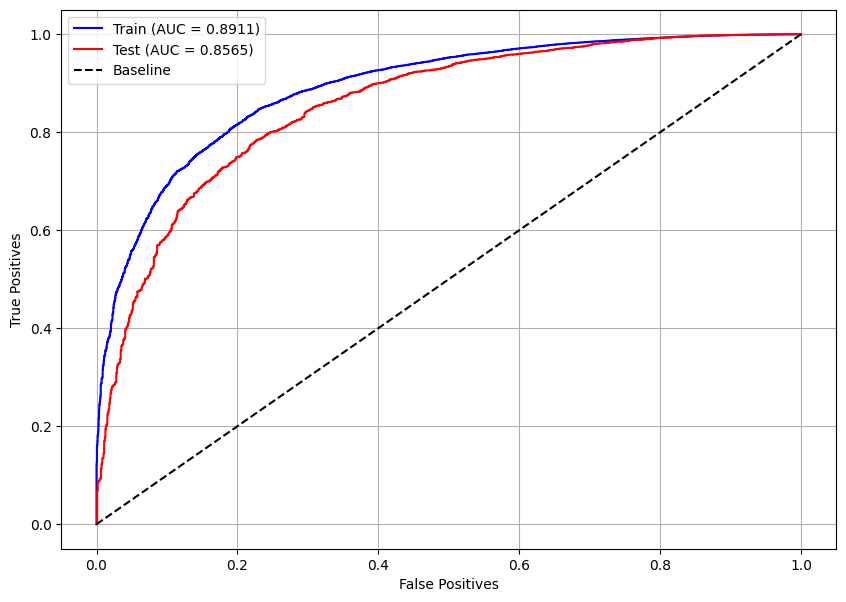

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 105,
 'max_depth': 4,
 'learning_rate': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(24.1, 24.4, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

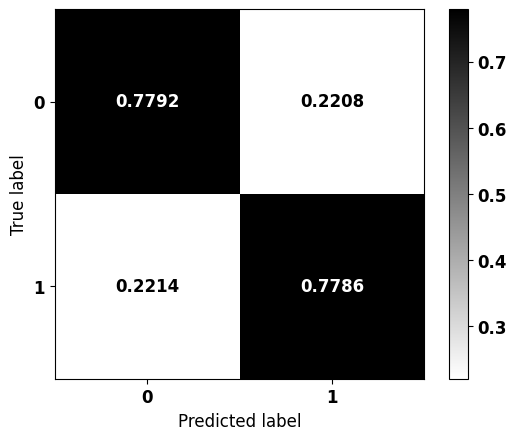


              precision    recall  f1-score   support

           0     0.1538    0.7792    0.2569      1105
           1     0.9856    0.7786    0.8699     21395

    accuracy                         0.7786     22500
   macro avg     0.5697    0.7789    0.5634     22500
weighted avg     0.9447    0.7786    0.8398     22500



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:24.28, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

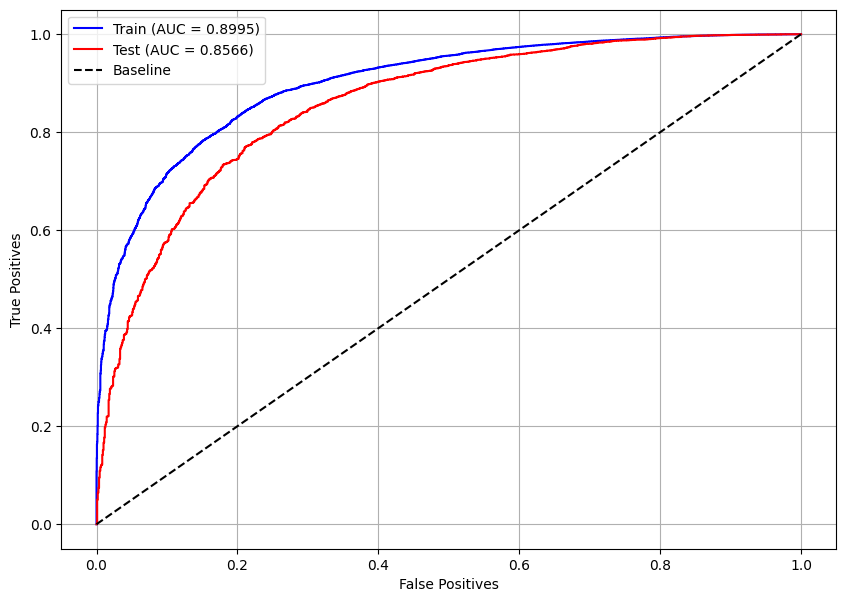

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

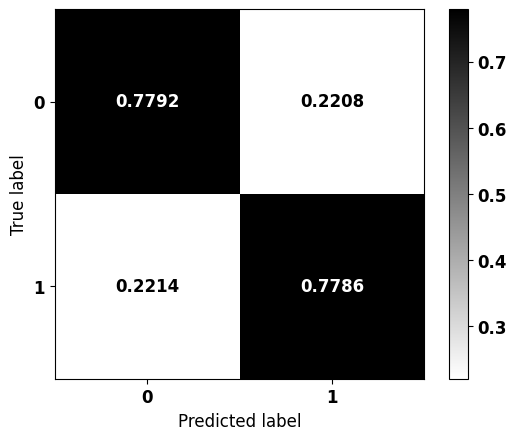


              precision    recall  f1-score   support

           0     0.1538    0.7792    0.2569      1105
           1     0.9856    0.7786    0.8699     21395

    accuracy                         0.7786     22500
   macro avg     0.5697    0.7789    0.5634     22500
weighted avg     0.9447    0.7786    0.8398     22500



In [44]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.2,
          'min_child_weight': 5, 'colsample_bytree': 0.5}

params['random_state'] = seed
params['class_weight'] = {0:24.28, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

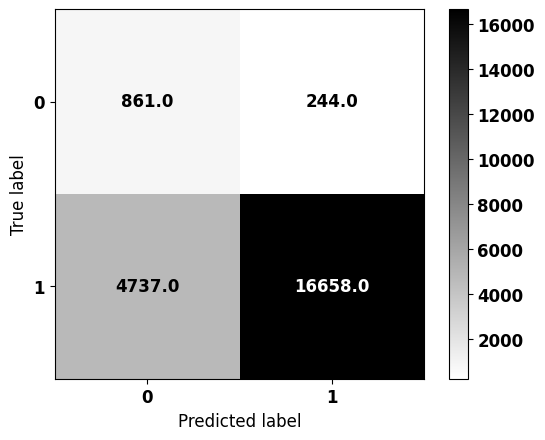


              precision    recall  f1-score   support

           0     0.1538    0.7792    0.2569      1105
           1     0.9856    0.7786    0.8699     21395

    accuracy                         0.7786     22500
   macro avg     0.5697    0.7789    0.5634     22500
weighted avg     0.9447    0.7786    0.8398     22500



In [ ]:
# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test, norm=False)

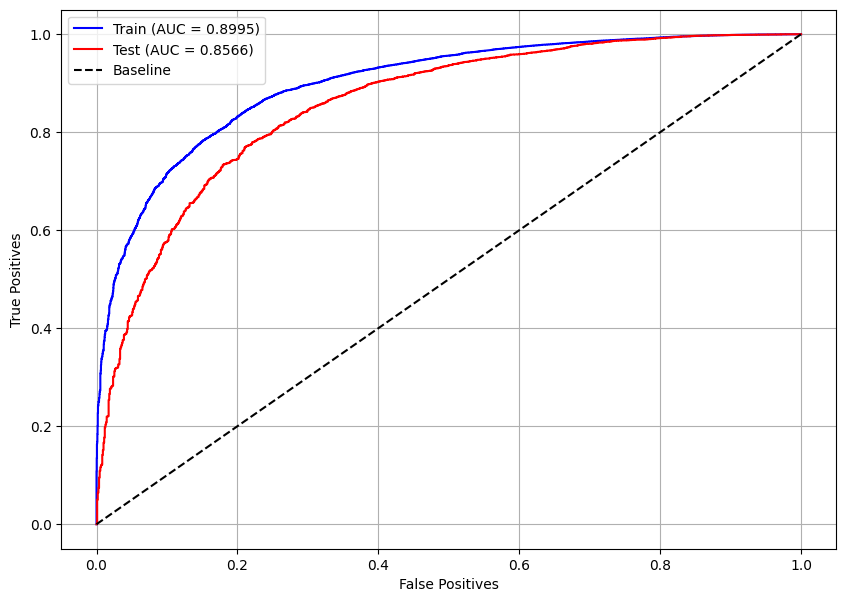

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

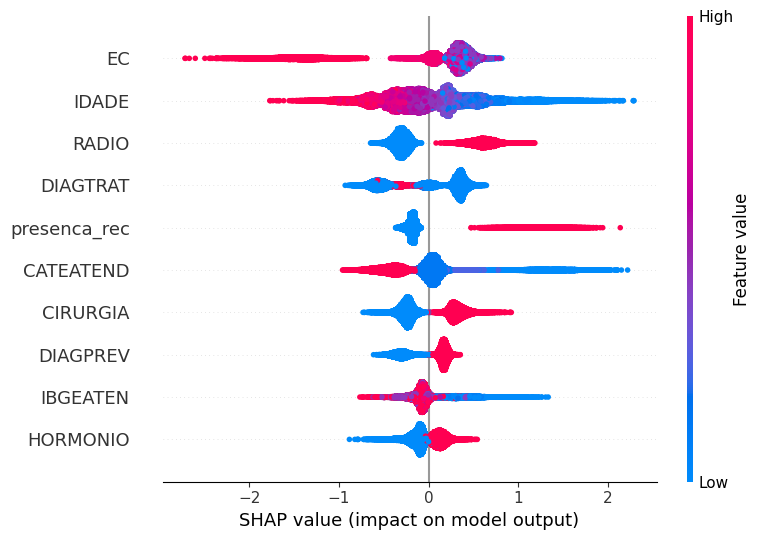

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [45]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7678, Optuna = 0.7668

Modelo inicial venceu


In [46]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7749, Optuna = 0.7774

Otimizado venceu


In [47]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7734, Optuna = 0.7786

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 24.28, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.2, max_depth=4, min_child_weight=5,
               n_estimators=105, random_state=7, verbose=-1)

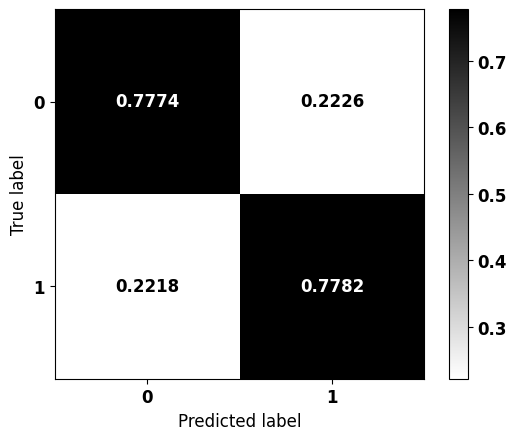


              precision    recall  f1-score   support

           0     0.1533    0.7774    0.2560      1105
           1     0.9854    0.7782    0.8696     21395

    accuracy                         0.7781     22500
   macro avg     0.5693    0.7778    0.5628     22500
weighted avg     0.9446    0.7781    0.8395     22500



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[#('RandomForest', best_rf),
                                   ('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

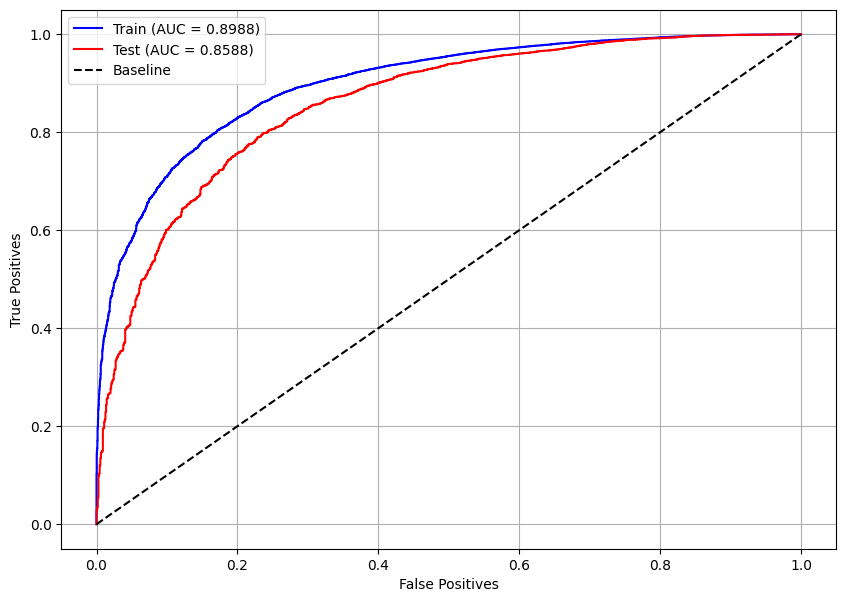

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [48]:
# Melhor modelo
models = [rf, rf_optuna, xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 24.28, 1: 1}, colsample_bytree=0.5,
               learning_rate=0.2, max_depth=4, min_child_weight=5,
               n_estimators=105, random_state=7, verbose=-1)


In [ ]:
# Colunas que não serão utilizadas na predição cruzada
list_drop = list_drop + [lb]
list_drop

['TRATHOSP',
 'TOPO',
 'TOPOGRUP',
 'obito_geral',
 'sobrevida_ano3',
 'sobrevida_ano5',
 'sobrevida_ano1']

### **Colorretal**

In [ ]:
df_colorretal = pd.read_csv('/content/colorretal.csv')
print(df_colorretal.shape)
df_colorretal.head(3)

(60887, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


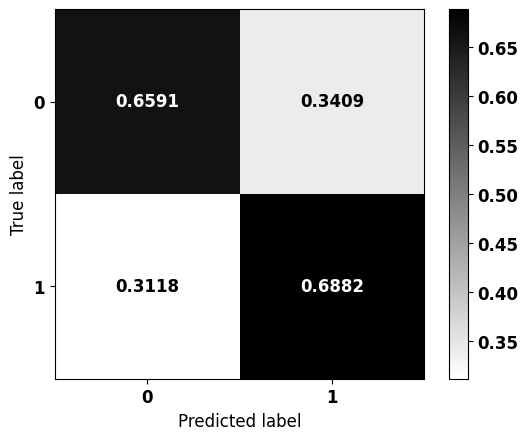


              precision    recall  f1-score   support

           0     0.3770    0.6591    0.4796     13079
           1     0.8758    0.6882    0.7708     45697

    accuracy                         0.6817     58776
   macro avg     0.6264    0.6737    0.6252     58776
weighted avg     0.7648    0.6817    0.7060     58776



In [ ]:
pred_cruzada(df_colorretal, best, list_drop, lb, enc, norm)

### **Pulmão**

In [ ]:
df_pulmao = pd.read_csv('/content/pulmao.csv')
print(df_pulmao.shape)
df_pulmao.head(3)

(38646, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


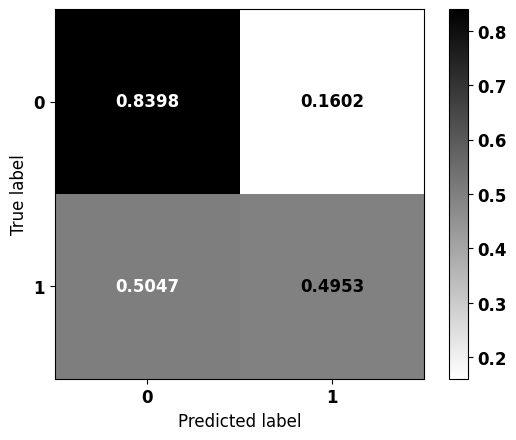


              precision    recall  f1-score   support

           0     0.7140    0.8398    0.7718     22687
           1     0.6733    0.4953    0.5707     15124

    accuracy                         0.7020     37811
   macro avg     0.6936    0.6675    0.6713     37811
weighted avg     0.6977    0.7020    0.6914     37811



In [ ]:
pred_cruzada(df_pulmao, best, list_drop, lb, enc, norm)

### **Mama**

In [ ]:
df_mama = pd.read_csv('/content/mama.csv')
print(df_mama.shape)
df_mama.head(3)

(117338, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,102,2,3550308,9,1,C509,C50,IIIB,D,0,...,6,3550308,2,3.0,1,1,1,1,0,0
1,28,2,3547809,9,2,C500,C50,I,G,0,...,1,3547809,1,4.0,1,0,1,1,1,1
2,27,2,3512001,2,2,C500,C50,I,H,0,...,13,3505500,2,4.0,0,1,0,1,1,1


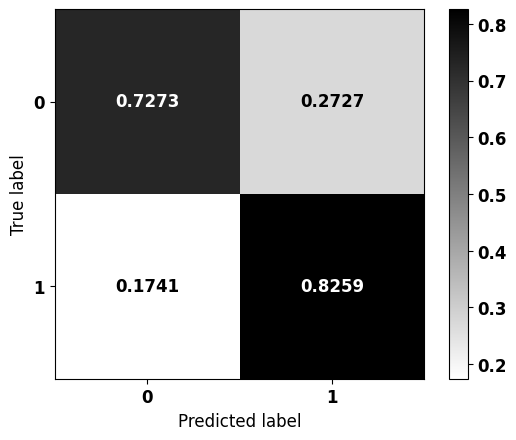


              precision    recall  f1-score   support

           0     0.2042    0.7273    0.3189      6546
           1     0.9801    0.8259    0.8964    106549

    accuracy                         0.8202    113095
   macro avg     0.5922    0.7766    0.6077    113095
weighted avg     0.9352    0.8202    0.8630    113095



In [ ]:
pred_cruzada(df_mama, best, list_drop, lb, enc, norm)

### **Colo de Útero**

In [ ]:
df_colo_utero = pd.read_csv('/content/colo_utero.csv')
print(df_colo_utero.shape)
df_colo_utero.head(3)

(23306, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,27,2,3548906,9,2,C530,C53,IIIB,B,0,...,13,3503208,1,4.0,0,0,1,1,0,0
1,29,2,3518701,9,1,C530,C53,IB2,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0
2,29,2,3522109,2,2,C530,C53,IB1,A,0,...,7,3550308,2,3.0,0,1,0,1,1,1


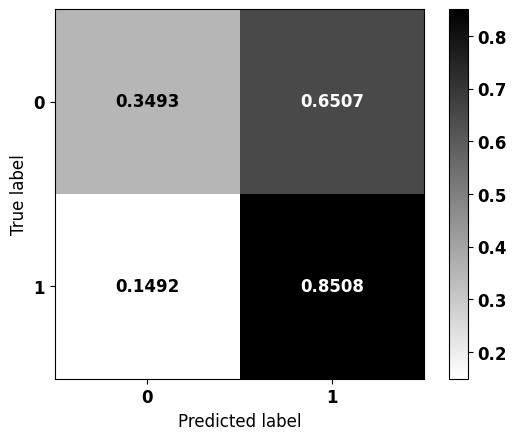


              precision    recall  f1-score   support

           0     0.3569    0.3493    0.3530      4300
           1     0.8465    0.8508    0.8487     18142

    accuracy                         0.7547     22442
   macro avg     0.6017    0.6000    0.6008     22442
weighted avg     0.7527    0.7547    0.7537     22442



In [ ]:
pred_cruzada(df_colo_utero, best, list_drop, lb, enc, norm)

### **Pele**

In [ ]:
df_pele = pd.read_csv('/content/pele.csv')
print(df_pele.shape)
df_pele.head(3)

(183164, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,101,2,3543402,9,1,C443,C44,I,I,0,...,13,3543402,2,2.0,1,0,1,1,0,0
1,100,1,3522802,2,1,C443,C44,II,A,0,...,9,3525300,2,1.0,0,0,1,1,0,0
2,105,2,3546603,9,1,C447,C44,I,A,0,...,12,3505500,2,1.0,0,0,1,0,0,0


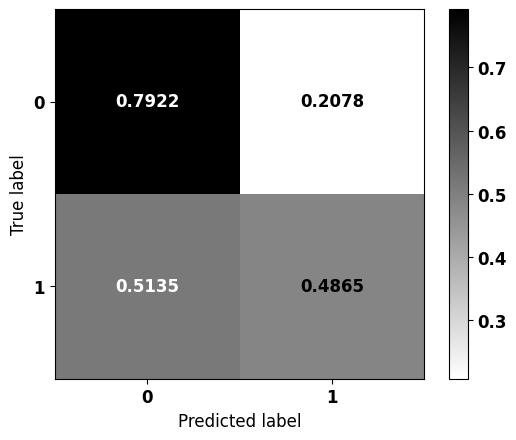


              precision    recall  f1-score   support

           0     0.0990    0.7922    0.1760      8108
           1     0.9705    0.4865    0.6481    113813

    accuracy                         0.5069    121921
   macro avg     0.5347    0.6394    0.4121    121921
weighted avg     0.9125    0.5069    0.6167    121921



In [ ]:
pred_cruzada(df_pele, best, list_drop, lb, enc, norm)